In [ ]:
import os
import pandas as pd 
import numpy as np
import geopandas as gpd

from pyproj import Transformer
from pyproj import CRS, Proj

from osgeo import gdal 
import rasterio
from rasterio.windows import from_bounds
from shapely.geometry import Point


import xarray as xr
import geopy.distance

In [246]:
# Load the generation data
path = os.getcwd() + "\\Raw_Spatial_Data\\Gen 2016-2023_vs edit.xlsx"
gen_data_wet = pd.read_excel(path,"2022")
gen_data_wet.drop(columns=['Export Capacity (MW)'],inplace=True)

gen_data_dry = pd.read_excel(path,"2019")
gen_data_dry.drop(columns=['Export Capacity (MW)'],inplace=True)

### Plant Data

In [247]:
# Load the plant data (head, location, etc.)
path = os.getcwd() + "\\Raw_Spatial_Data\\19.7.2024-NEW UPDATED_Data_lao_231223_NPP_coordinate.xlsx"
data = pd.read_excel(path,'NPDP power plant info')

In [248]:
# PREP OF PLANT DATA
data = data[['SNo', 'East E', 'North N', 'Status', 'PP name', 'New Ose_Name','Fuel Type',
       'Province', 'Region', 'Total capacity (MW)',
       'Domestic Capacity (MW)', 'Export Capacity (MW)',
       'Expected Generation (GWh)',
       'total theoretical possible generation (local) GWh', 'COD (Year)',
       'Exporting country country', 'Head Hydraulic (m)']]

data['East E'] = pd.to_numeric(data['East E'], errors='coerce')
data['North N'] = pd.to_numeric(data['North N'], errors='coerce')

data = data.dropna(subset=['East E', 'North N'])

transformer = Transformer.from_crs("epsg:32648", "epsg:4326", always_xy=True)

def convert_coordinates(easting, northing):
    longitude, latitude = transformer.transform(easting, northing)
    return latitude, longitude

converted_coords = data.apply(
    lambda row: convert_coordinates(row['East E'], row['North N']),
    axis=1
)

data = data.copy()
data[['Latitude', 'Longitude']] = pd.DataFrame(converted_coords.tolist(), index=data.index)
data[['East E','North N','Latitude','Longitude']]

data = data[['SNo', 'New Ose_Name', 'PP name','Status','Fuel Type','Latitude','Longitude','Total capacity (MW)','Domestic Capacity (MW)',
             'Expected Generation (GWh)','total theoretical possible generation (local) GWh',
             'COD (Year)','Head Hydraulic (m)']]
data = data.rename(columns={"COD (Year)": "COD",
                            "PP name": "name",
                            # "Total capacity (MW)": "capacity",
                            "Head Hydraulic (m)": "head"})

data = data[data['Fuel Type'].isin(['Run - Off', 'Reservoir '])]
data['Total capacity (MW)'] = pd.to_numeric(data['Total capacity (MW)'], errors='raise')

data['Fuel Type'] = data['Fuel Type'].str.replace("Reservoir ", "Reservoir")
data.to_excel("hydropower_list_seasonal.xlsx", index=False)

### Hydrological Network

In [249]:
# Coordinate Reference Systems
wgs84 = CRS("EPSG:4326")
merc = CRS("EPSG:3395")
merc_pro = Proj("EPSG:3395")

class LocalHydroNetwork:
    def __init__(self, dem_path, flow_path, flow_acc_path):
        self.dem = rasterio.open(dem_path)
        self.flow = rasterio.open(flow_path)
        self.flow_acc = rasterio.open(flow_acc_path)

    def create_local_network(self, point, buffer=0.005):
        minx, miny = point.x - buffer, point.y - buffer
        maxx, maxy = point.x + buffer, point.y + buffer

        window = rasterio.windows.from_bounds(minx, miny, maxx, maxy, self.dem.transform)
        dem_local = self.dem.read(1, window=window)
        flow_local = self.flow.read(1, window=window)
        flow_acc_local = self.flow_acc.read(1, window=window)

        transform = rasterio.windows.transform(window, self.dem.transform)

        nodes, arcs = self._extract_nodes_arcs(dem_local, flow_local, flow_acc_local, transform)
        return nodes, arcs

    def _extract_nodes_arcs(self, dem_local, flow_local, flow_acc_local, transform):
        nodes = []
        arcs = []
        height, width = dem_local.shape
        node_index_map = {}

        for i in range(height):
            for j in range(width):
                x, y = transform * (j, i)
                elevation = dem_local[i, j]
                flow_dir = flow_local[i, j]
                flow_acc = flow_acc_local[i, j]

                current_node = (i, j)
                if current_node not in node_index_map:
                    node_id = len(nodes)
                    node = {
                        'id': node_id,
                        'x': x,
                        'y': y,
                        'elevation': elevation,
                        'flow_acc': flow_acc,
                        'arcs': []
                    }
                    nodes.append(node)
                    node_index_map[current_node] = node_id
                else:
                    node_id = node_index_map[current_node]

                if flow_dir > 0:
                    next_i, next_j = self._flow_direction_to_indices(i, j, flow_dir)
                    if 0 <= next_i < height and 0 <= next_j < width:
                        next_node = (next_i, next_j)
                        if next_node not in node_index_map:
                            next_node_id = len(nodes)
                            next_x, next_y = transform * (next_j, next_i)
                            next_elevation = dem_local[next_i, next_j]
                            next_flow_acc = flow_acc_local[next_i, next_j]

                            next_node_data = {
                                'id': next_node_id,
                                'x': next_x,
                                'y': next_y,
                                'elevation': next_elevation,
                                'flow_acc': next_flow_acc,
                                'arcs': []
                            }
                            nodes.append(next_node_data)
                            node_index_map[next_node] = next_node_id
                        else:
                            next_node_id = node_index_map[next_node]

                        arc = {
                            'start_node': node_id,
                            'end_node': next_node_id,
                            'length': np.hypot(next_i - i, next_j - j)
                        }
                        nodes[node_id]['arcs'].append(arc)
                        arcs.append(arc)

        return nodes, arcs

    def _flow_direction_to_indices(self, i, j, direction):
        if direction == 1:  # East
            return i, j + 1
        elif direction == 2:  # Southeast
            return i + 1, j + 1
        elif direction == 4:  # South
            return i + 1, j
        elif direction == 8:  # Southwest
            return i + 1, j - 1
        elif direction == 16:  # West
            return i, j - 1
        elif direction == 32:  # Northwest
            return i - 1, j - 1
        elif direction == 64:  # North
            return i - 1, j
        elif direction == 128:  # Northeast
            return i - 1, j + 1
        else:
            return i, j  # No direction

    def calculate_head(self, nodes, arcs):
        max_head = 0
        for arc in arcs:
            start_node = nodes[arc['start_node']]
            end_node = nodes[arc['end_node']]
            head = start_node['elevation'] - end_node['elevation']
            if head > max_head:
                max_head = head
        return max_head

    def process_hydropower_plants(self, df, buffer):
        df['head_calculated'] = pd.NA
        for index, row in df.iterrows():
            point = Point(row['Longitude'], row['Latitude'])
            nodes, arcs = self.create_local_network(point, buffer)
            head = self.calculate_head(nodes, arcs)
            df.at[index, 'head_calculated'] = head
        df['head_difference'] = df['head'] - df['head_calculated']
        return df

    def optimize_buffer(self, df, buffer_range):
        best_mae = float('inf')
        best_std = float('inf')
        best_buffer = None
        best_df = None
        
        for buffer in buffer_range:
            df_processed = self.process_hydropower_plants(df.copy(), buffer)
            mae = df_processed['head_difference'].abs().mean()
            std = df_processed['head_difference'].std()
            if mae + std < best_mae + best_std:
                best_mae = mae
                best_std = std
                best_buffer = buffer
                best_df = df_processed
        
        print(f"Optimal Buffer: {best_buffer}")
        print(f"Mean Absolute Error: {best_mae}")
        print(f"Standard Deviation: {best_std}")
        
        return best_df, best_buffer, best_mae, best_std

    def optimize_for_fuel_types(self, df, buffer_range):
        # Optimize only for rows with existing head values
        reservoir_df = df[df['Fuel Type'] == 'Reservoir'].dropna(subset=['head']).copy()
        runoff_df = df[df['Fuel Type'] == 'Run - Off'].dropna(subset=['head']).copy()

        print("\nOptimizing for Reservoir plants...")
        optimized_reservoir_df, optimal_reservoir_buffer, reservoir_mae, reservoir_std = self.optimize_buffer(reservoir_df, buffer_range)
        
        print("\nOptimizing for Run - Off plants...")
        optimized_runoff_df, optimal_runoff_buffer, runoff_mae, runoff_std = self.optimize_buffer(runoff_df, buffer_range)

        return {
            'reservoir': {
                'df': optimized_reservoir_df, 
                'buffer': optimal_reservoir_buffer, 
                'mae': reservoir_mae, 
                'std': reservoir_std
            },
            'runoff': {
                'df': optimized_runoff_df, 
                'buffer': optimal_runoff_buffer, 
                'mae': runoff_mae, 
                'std': runoff_std
            }
        }

    def calculate_and_fill_missing_heads(self, df, reservoir_buffer, runoff_buffer):
        # Process all rows with the optimized buffer sizes
        df_reservoir = self.process_hydropower_plants(df[df['Fuel Type'] == 'Reservoir'].copy(), reservoir_buffer)
        df_runoff = self.process_hydropower_plants(df[df['Fuel Type'] == 'Run - Off'].copy(), runoff_buffer)

        # Combine results back into the original DataFrame
        df_combined = pd.concat([df_reservoir, df_runoff])

        # Fill missing head values in the original DataFrame
        for index, row in df_combined.iterrows():
            if pd.isna(df.at[index, 'head']):
                df.at[index, 'head'] = df_combined.at[index, 'head_calculated']

        return df

In [250]:
path = os.getcwd()
dem_path = path + "\\Raw_Spatial_Data\\hydro_data\\dem_con_asia.tif"
flow_path = path + "\\Raw_Spatial_Data\\hydro_data\\flow_asia.tif"
flow_acc_path = path + "\Raw_Spatial_Data\\hydro_data\\as_acc_3s.tif"
xlsx_file = "hydropower_list_seasonal.xlsx"

buffer_range = np.linspace(0.00025, 0.005, 101)
hydro_network = LocalHydroNetwork(dem_path, flow_path, flow_acc_path)

df = pd.read_excel(xlsx_file)
results = hydro_network.optimize_for_fuel_types(df, buffer_range)

plant_data = hydro_network.calculate_and_fill_missing_heads(df, results['reservoir']['buffer'], results['runoff']['buffer'])


Optimizing for Reservoir plants...
Optimal Buffer: 0.003385
Mean Absolute Error: 26.0828125
Standard Deviation: 29.08527294557416

Optimizing for Run - Off plants...
Optimal Buffer: 0.003195
Mean Absolute Error: 45.85
Standard Deviation: 84.40090732862258


### Merge Data

In [251]:
# Check for mismatches and display differing rows
overlapping_columns = ['Domestic Capacity (MW)'] # 'Total capacity (MW)', 

# Perform inner merge for comparison
merged_for_comparison = pd.merge(
    plant_data, gen_data_wet,
    left_on='New Ose_Name', right_on='OSeMOSYS tech',
    how='inner',
    suffixes=('_plant', '_wet')
)

# Iterate through overlapping columns to find and display mismatches
for col in overlapping_columns:
    diff_rows = merged_for_comparison[merged_for_comparison[f'{col}_plant'] != merged_for_comparison[f'{col}_wet']]
    
    if not diff_rows.empty:
        print(f"Rows with differing values in column '{col}':")
        display(diff_rows)
    else:
        print(f"No differing values in column '{col}'.")


Rows with differing values in column 'Domestic Capacity (MW)':


,SNo,New Ose_Name,name,Status,Fuel Type,Latitude,Longitude,Total capacity (MW)_plant,Domestic Capacity (MW)_plant,Expected Generation (GWh),...,Jun,Jul,Aug,Sep,Oct,Nov,Dec,OSeMOSYS tech,Total capacity (MW)_wet,Domestic Capacity (MW)_wet
6,9,PWRHYD009CEN,Nam Theun 2,Existing,Reservoir,17.997514,104.952542,1080.0,75.276,6000.0,...,28.608600,31.128700,17.343600,18.516500,15.467000,12.560000,11.684400,PWRHYD009CEN,75.0,75.0
55,76,PWRHYD067CEN,Nam Ngum 1 EX phase 2 (6),Existing,Reservoir,18.531179,102.547716,120.0,40.000,59.0,...,37.457872,24.056480,7.461600,0.000000,0.000000,0.000000,0.000000,PWRHYD067CEN,120.0,120.0
57,81,PWRHYD072SOU,Xelabam,Existing,Run - Off,15.354007,105.833261,13.5,13.500,57.0,...,3.426643,3.681152,3.460402,3.281309,3.570649,3.514803,3.531307,PWRHYD072SOU,13.0,13.0


In [252]:
gen_data_wet = gen_data_wet.drop(columns=['Total capacity (MW)','Domestic Capacity (MW)'])
merged_data_wet = pd.merge(plant_data, gen_data_wet, left_on='New Ose_Name', right_on='OSeMOSYS tech', how='left')
for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
    merged_data_wet[month] = merged_data_wet[month].fillna(0)

gen_data_dry = gen_data_dry.drop(columns=['Total capacity (MW)','Domestic Capacity (MW)'])
merged_data_dry = pd.merge(plant_data, gen_data_dry, left_on='New Ose_Name', right_on='OSeMOSYS tech', how='left')
for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
    merged_data_dry[month] = merged_data_dry[month].fillna(0)

In [253]:
merged_data_wet.columns

Index(['SNo', 'New Ose_Name', 'name', 'Status', 'Fuel Type', 'Latitude',
       'Longitude', 'Total capacity (MW)', 'Domestic Capacity (MW)',
       'Expected Generation (GWh)',
       'total theoretical possible generation (local) GWh', 'COD', 'head',
       'Name', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec', 'OSeMOSYS tech'],
      dtype='object')

### Capacity Factor Calculation

In [413]:
def calculate_capacity_factors(data, monthly_columns, hours_in_month):
    # Initialize a dictionary to store smoothed hourly capacity factors for each plant
    plant_capacity_factors = {}

    # Iterate over each plant in the dataset
    for index, row in data.iterrows():
        plant_name = row['name']
        plant_capacity = row['Total capacity (MW)']

        # Generate a list to hold monthly capacity factors for the plant
        monthly_capacity_factors = []
        for month in monthly_columns:
            monthly_generation = row[month] * 1000  # Convert GWh to MWh
            monthly_capacity_factor = (monthly_generation / hours_in_month[month]) / plant_capacity
            monthly_capacity_factors.append(monthly_capacity_factor)

        # Extend time index to include January 2024 for boundary smoothing
        extended_monthly_time_index = pd.date_range(start='2023-01-01', end='2024-01-01', freq='MS')
        extended_monthly_capacity_factors = monthly_capacity_factors + [monthly_capacity_factors[-1]]

        # Create a Series with extended monthly capacity factors
        extended_monthly_series = pd.Series(data=extended_monthly_capacity_factors, index=extended_monthly_time_index)

        # Interpolate to create hourly data using cubic interpolation
        hourly_series = extended_monthly_series.resample('h').interpolate(method='cubic')

        # Trim to the full hourly range for 2023 (8760 hours)
        full_time_index = pd.date_range(start='2023-01-01 00:00', end='2023-12-31 23:00', freq='H')
        hourly_series = hourly_series.reindex(full_time_index, method='nearest')

        # Store the plant's smoothed hourly capacity factors in the dictionary
        plant_capacity_factors[plant_name] = hourly_series

    # Combine all plants into a single DataFrame
    smoothed_capacity_factors = pd.DataFrame(plant_capacity_factors)

    # Clip capacity factors to be within [0, 1]
    smoothed_capacity_factors = smoothed_capacity_factors.clip(lower=0, upper=1)

    # Drop any remaining NaNs (if any)
    smoothed_capacity_factors.dropna(axis=0, how='any', inplace=True)

    return smoothed_capacity_factors


In [414]:
# Define monthly columns and hours in each month for 2023
monthly_columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
hours_in_month = {
    'Jan': 744, 'Feb': 672, 'Mar': 744, 'Apr': 720,
    'May': 744, 'Jun': 720, 'Jul': 744, 'Aug': 744,
    'Sep': 720, 'Oct': 744, 'Nov': 720, 'Dec': 744
}

# Step 1: Calculate capacity factors
smoothed_capacity_factors_wet = calculate_capacity_factors(merged_data_wet, monthly_columns, hours_in_month)
smoothed_capacity_factors_dry = calculate_capacity_factors(merged_data_dry, monthly_columns, hours_in_month)

### Calculate average capacity factors for empty plants 

In [347]:
laos_hydrobasins = gpd.read_file('Raw_Spatial_Data\hydro_data\hydrobasins\hybas_as_lev08_v1c\hybas_as_lev08_v1c.shp')

In [415]:
# Convert latitude and longitude to a GeoDataFrame for spatial join
plants_gdf = gpd.GeoDataFrame(
    data=merged_data_wet,  # Or merged_data_dry
    geometry=gpd.points_from_xy(merged_data_wet['Longitude'], merged_data_wet['Latitude']),
    crs=laos_hydrobasins.crs
)

# Step 2: Map plants to basins
plants_with_basins = gpd.sjoin(plants_gdf, laos_hydrobasins, how='left', op='intersects')
plant_to_basin_mapping = plants_with_basins.set_index('name')['HYBAS_ID']

c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2-data-prep\lib\site-packages\IPython\core\interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [416]:
def update_zero_rows_with_basin_average(capacity_factors, plant_to_basin_mapping):
    # Identify plants (columns) with all 0s across all hours
    zero_plants = (capacity_factors == 0).all(axis=0)
    # Iterate over each basin and calculate the basin average
    for basin in plant_to_basin_mapping.unique():
        # Get plants in this basin
        plants_in_basin = plant_to_basin_mapping[plant_to_basin_mapping == basin].index

        # Get rows corresponding to these plants
        rows_in_basin = capacity_factors[plants_in_basin]

        # Calculate the basin average for non-zero plants
        basin_average = rows_in_basin.loc[:, ~zero_plants[plants_in_basin]].mean(axis=1)
        print(basin_average)
        # Update plants with all 0s for this basin
        for plant in plants_in_basin:
            if zero_plants[plant]:
                capacity_factors[plant] = basin_average

    return capacity_factors

# Step 3: Update zero rows
updated_capacity_factors = update_zero_rows_with_basin_average(smoothed_capacity_factors_wet, plant_to_basin_mapping)

2023-01-01 00:00:00    0.283597
2023-01-01 01:00:00    0.283189
2023-01-01 02:00:00    0.282782
2023-01-01 03:00:00    0.282378
2023-01-01 04:00:00    0.282210
                         ...   
2023-12-31 19:00:00    0.199088
2023-12-31 20:00:00    0.199085
2023-12-31 21:00:00    0.199083
2023-12-31 22:00:00    0.199080
2023-12-31 23:00:00    0.199077
Freq: H, Length: 8760, dtype: float64
2023-01-01 00:00:00    0.164186
2023-01-01 01:00:00    0.164077
2023-01-01 02:00:00    0.163969
2023-01-01 03:00:00    0.163861
2023-01-01 04:00:00    0.163753
                         ...   
2023-12-31 19:00:00    0.237841
2023-12-31 20:00:00    0.237848
2023-12-31 21:00:00    0.237855
2023-12-31 22:00:00    0.237861
2023-12-31 23:00:00    0.237867
Freq: H, Length: 8760, dtype: float64
2023-01-01 00:00:00   NaN
2023-01-01 01:00:00   NaN
2023-01-01 02:00:00   NaN
2023-01-01 03:00:00   NaN
2023-01-01 04:00:00   NaN
                       ..
2023-12-31 19:00:00   NaN
2023-12-31 20:00:00   NaN
2023-12-31 2

In [417]:
def update_zero_rows_with_basin_average(capacity_factors, plant_to_basin_mapping, plants_location_data, max_radius_km=100):
    """
    Update plants with all 0s by first using basin averages, and for remaining zero plants, incrementally
    expand the radius to find nearby plants in 10 km steps.

    Args:
        capacity_factors (pd.DataFrame): Capacity factors with plants as columns and time as rows.
        plant_to_basin_mapping (pd.Series): Mapping of plants to their basins.
        plants_location_data (pd.DataFrame): DataFrame with plant names, latitudes, and longitudes.
        max_radius_km (float): Maximum radius for searching nearby plants.

    Returns:
        pd.DataFrame: Updated capacity factors.
    """
    # Identify plants (columns) with all 0s across all hours
    zero_plants = (capacity_factors == 0).all(axis=0)

    # Step 1: Basin Averages
    for basin in plant_to_basin_mapping.unique():
        # Get plants in this basin
        plants_in_basin = plant_to_basin_mapping[plant_to_basin_mapping == basin].index

        # Get rows corresponding to these plants
        rows_in_basin = capacity_factors[plants_in_basin]

        # Calculate the basin average for non-zero plants
        basin_average = rows_in_basin.loc[:, ~zero_plants[plants_in_basin]].mean(axis=1)

        # Update plants with all 0s for this basin
        for plant in plants_in_basin:
            if zero_plants[plant]:
                if not basin_average.isna().all():
                    # Use basin average for the plant
                    capacity_factors[plant] = basin_average

    # Recompute zero plants after basin updates
    zero_plants = (capacity_factors == 0).all(axis=0) | capacity_factors.isna().all(axis=0)

    # Step 2: Incremental Radius Expansion for Remaining Zero Plants
    remaining_zero_plants = zero_plants[zero_plants].index  # Plants still with all 0s
    for radius_km in range(10, max_radius_km + 10, 10):
        for plant in remaining_zero_plants:
            if zero_plants[plant]:
                plant_location = plants_location_data.loc[plant]
                nearby_plants = []

                # Find nearby plants within the current radius
                for other_plant, location in plants_location_data.iterrows():
                    if other_plant != plant:
                        dist = geopy.distance.distance(
                            (plant_location['Latitude'], plant_location['Longitude']),
                            (location['Latitude'], location['Longitude'])
                        ).km
                        if dist <= radius_km:
                            nearby_plants.append(other_plant)

                # Calculate the average from nearby plants
                if nearby_plants:
                    nearby_average = capacity_factors[nearby_plants].loc[:, ~zero_plants[nearby_plants]].mean(axis=1)
                    if not nearby_average.isna().all():
                        capacity_factors[plant] = nearby_average
                        zero_plants[plant] = False  # Mark plant as updated

        # Recompute remaining zero plants after each radius increment
        remaining_zero_plants = zero_plants[zero_plants].index

        # If no zero plants remain, exit the loop
        if remaining_zero_plants.empty:
            break

    return capacity_factors


In [418]:
# Example max radius for nearby plants
max_radius_km = 100

# Update capacity factors for smoothed_capacity_factors_wet
updated_capacity_factors_wet = update_zero_rows_with_basin_average(
    capacity_factors=smoothed_capacity_factors_wet,
    plant_to_basin_mapping=plant_to_basin_mapping,
    plants_location_data=merged_data_wet[['name', 'Latitude', 'Longitude']].set_index('name'),
    max_radius_km=max_radius_km
)

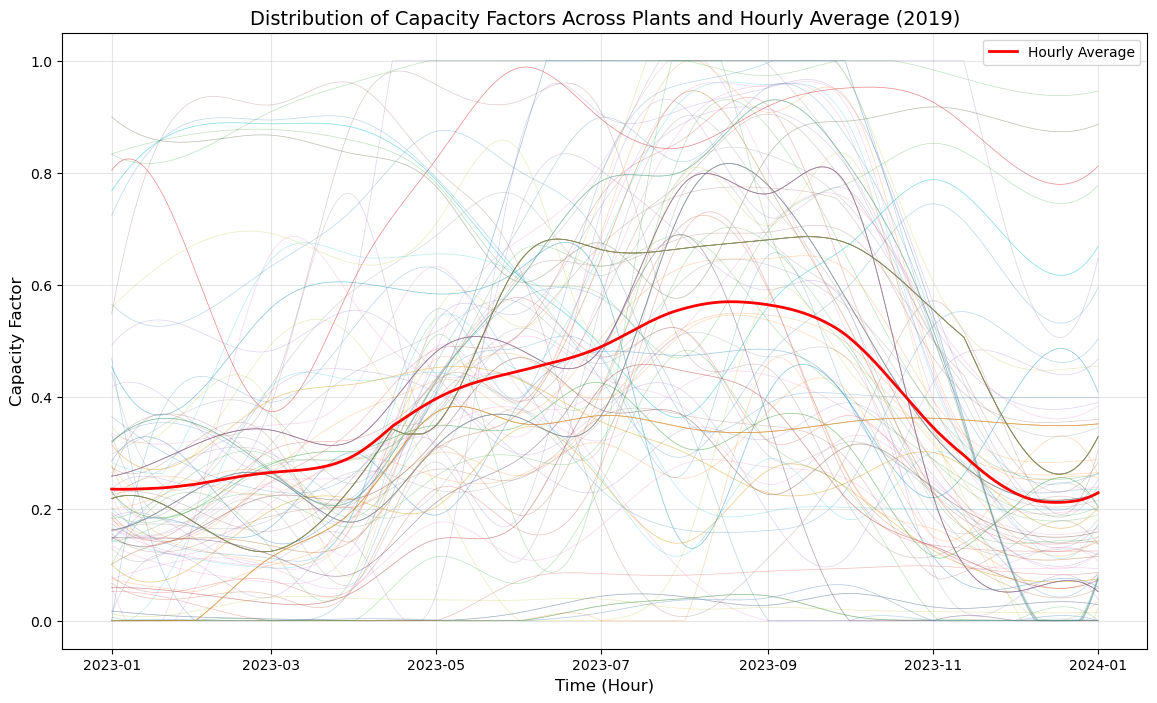

In [419]:
import matplotlib.pyplot as plt

# Function to visualize capacity factors for a single year
def plot_capacity_factors(capacity_factor, year):
    # Calculate the average capacity factor for each hour across all plants
    hourly_average = capacity_factor.mean(axis=1)

    # Set up the figure and axis
    plt.figure(figsize=(14, 8))

    # Plot the individual capacity factors for each plant as transparent lines
    for plant in capacity_factor.columns:
        plt.plot(capacity_factor.index, capacity_factor[plant], alpha=0.3, linewidth=0.5, label='_nolegend_')

    # Plot the hourly average capacity factor as a bold line
    plt.plot(hourly_average.index, hourly_average.values, color='red', label='Hourly Average', linewidth=2)

    # Add title, labels, and legend
    plt.title(f'Distribution of Capacity Factors Across Plants and Hourly Average ({year})', fontsize=14)
    plt.xlabel('Time (Hour)', fontsize=12)
    plt.ylabel('Capacity Factor', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    # Display the plot
    plt.show()

    # Optionally, save the plot to a file
    # plt.savefig(f"capacity_factor_distribution_{year}.png", dpi=300)

# Plot for 2019
plot_capacity_factors(updated_capacity_factors_wet, 2019)

In [420]:
def convert_to_xarray(capacity_factors, time_index):
    # Convert the DataFrame to an xarray DataArray
    capacity_factor_array = xr.DataArray(
        data=capacity_factors.values,
        dims=['time', 'plant'],
        coords={'time': time_index, 'plant': capacity_factors.columns}
    )
    return capacity_factor_array

# Step 4: Convert to xarray
time_index = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='H')
capacity_factor_array = convert_to_xarray(updated_capacity_factors_wet, time_index)

In [421]:
capacity_factor_array

<xarray.DataArray (time: 8760, plant: 123)> Size: 9MB
array([[0.56522728, 0.17855346, 0.22981452, ..., 0.25810242, 0.27655771,
        0.83372774],
       [0.56502466, 0.17845793, 0.22956737, ..., 0.25813814, 0.2760669 ,
        0.83379277],
       [0.56482262, 0.17836249, 0.22932096, ..., 0.25817406, 0.27557718,
        0.83385775],
       ...,
       [0.398156  , 0.25613387, 0.20471299, ..., 0.05229083, 0.15029307,
        0.77710835],
       [0.39815355, 0.25609497, 0.20437021, ..., 0.05212394, 0.15050719,
        0.7773211 ],
       [0.3981511 , 0.25605573, 0.20402611, ..., 0.05195621, 0.15072203,
        0.77753465]])
Coordinates:
  * time     (time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23:00:00
  * plant    (plant) object 984B 'Nam Ngum 1' 'Xeset1' ... 'Nam Bak 1'

In [422]:
count_ones = (capacity_factor_array == 1).sum().item()
total_values = capacity_factor_array.size
percentage_ones = (count_ones / total_values) * 100

print(f"Total number of 1s: {count_ones}")
print(f"Percentage of 1s: {percentage_ones:.2f}%")

Total number of 1s: 17159
Percentage of 1s: 1.59%
